In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools
from sklearn.decomposition import NMF, TruncatedSVD

In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

In [3]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]


def sites_to_sparse_tfidf(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
    test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

    y = train_data[target_col]

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
    train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                                  for i in range(train_test_df_sites.shape[0])]

    tfidf = TfidfVectorizer(max_df=0.9).fit(train_test_df_sites_array) #TfidfVectorizer()
    X_train_test_sparse = tfidf.transform(train_test_df_sites_array)

    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, \
             train_duplicates_mask, test_duplicates_mask]


def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix


def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse



def combine_sites_features_sparse(sites_train_sparse, features_train_sparse, \
                                  sites_test_sparse, features_test_sparse, \
                                  train_duplicates_mask, test_duplicates_mask, \
                                  train_site_times_sparse = None, test_site_times_sparse = None, \
                                train_sites_sequence=None, test_sites_sequence=None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse, \
                                 train_site_times_sparse, train_sites_sequence], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse, \
                                test_site_times_sparse, test_sites_sequence], dtype=float).tocsr()
    else:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
        
    X_train_sparse = hstack([X_train_sparse, train_duplicates_mask], dtype=float).tocsr()
    X_test_sparse = hstack([X_test_sparse, test_duplicates_mask], dtype=float).tocsr() 
    return [X_train_sparse, X_test_sparse]


def sparse_matrix_to_vw(X_sparse_full, sites_columns_num, vocabulary, y=None, weights=None, mark_duplicates=False, mycolumns=[]):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    sequence = {}
    
    lables = {}
    lable_weights = {}
    
    X_sparse = X_sparse_full[:,:-1]
    
    add_features = True

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if add_features:
                if c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("prediction") - 10:
                    prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                    #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week") - 10:
                    day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                    #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour") - 10:
                    start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                    #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("daytime") - 10:
                    daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                    #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan") - 10:
                    session_timespan[r] = " |jsession_timespan time:{}".format(int(X_sparse[r,c]))
                    #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites") - 10:
                    unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                    #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time") - 10:
                    site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                    #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion") - 10:
                    top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion") - 10:
                    bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion") - 10:
                    fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion") - 10:
                    youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                    continue
                elif c >= X_sparse.shape[1] - 10:
                    if r not in sequence:
                        sequence[r] = " |ksequence " + \
                            ' '.join(filter(lambda a: a != "0", X_sparse[r,-10:].todense().astype(int).astype(str).tolist()[0]))
                    continue
                    
            if c < sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                else:
                    if y is not None:
                        if int(X_sparse_full[r, -1]) and mark_duplicates: # duplicate row indicator
                            sessions[r] = ' 0.3' + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                        else:
                            sessions[r] = ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                        lables[r] = str(y[r])
                        if weights is not None:
                            lable_weights[r] = str(weights[y[r]-1])
                    else:
                        sessions[r] = ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
            elif c > X_sparse.shape[1] - sites_columns_num and c < X_sparse.shape[1] - 10:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "lables": lables, "lable_weights": lable_weights, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes, "sequence": sequence}



def vw_to_file(sites, out_file, features={}, lables={}, lable_weights={},  quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        if r in lables:
            final_vw[r] = lables[r]
        else:
            final_vw[r] = ""
        if r in lable_weights:
            final_vw[r] += " {}".format(lable_weights[r])
        final_vw[r] += sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()
    
    
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)



In [4]:
def calc_predictions(train_data, test_data):
    test_row_users = {}
    train_row_users = {}
    
    # Add predictions from the dataframe (based on uniquely visited site)
    for r, v in test_data[["prediction"]].iterrows():
        if int(v) != 0:
            test_row_users[r] = [int(v)]
    
    
    #Identify sessions with identical sites sequence
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)

    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    
    train_user_dup_rows_dict = {}
    train_dup_row_users_dict = {}

    test_dup_rows_dict = {}
    

    sites_cols = ['site' + str(c) for c in range(1,10+1)]
    
    for r, row in train_data.iloc[train_index_dup][sites_cols+["target"]].iterrows():
        if row["target"] in train_user_dup_rows_dict:
            if tuple(row[sites_cols]) in train_user_dup_rows_dict[row["target"]]:
                train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] += 1
            else:
                train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] = 1 
        else:
            train_user_dup_rows_dict[row["target"]] = {tuple(row[sites_cols]): 1}

        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            train_dup_row_users_dict[tuple(row[sites_cols])].add(row["target"])
        else:
            train_dup_row_users_dict[tuple(row[sites_cols])] = set([row["target"]])

    for r, row in test_data.iloc[test_index_dup][sites_cols].iterrows():  
        if tuple(row[sites_cols]) in test_dup_rows_dict:
            test_dup_rows_dict[tuple(row[sites_cols])] += 1
        else:
            test_dup_rows_dict[tuple(row[sites_cols])] = 1

        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            if r in test_row_users:
                pass #don't overwright predictions from the dataframe
                #test_row_users[r] += train_dup_row_users_dict[tuple(row[sites_cols])]
            else:
                test_row_users[r] = train_dup_row_users_dict[tuple(row[sites_cols])]
        
    # Find users who visited 2 websites
    site_pairs = {}
    for r, row in train_data[sites_cols+["target"]].iterrows():
        unique_sites = Counter(row).keys()
        if 0 in unique_sites:
            del unique_sites[unique_sites.index(0)]
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
        if len(unique_sites) > 3:
            for subset in itertools.permutations(Counter(row).keys(), 4):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
    
    
    # Add predictions to test data based on 2 visited websites
    for r, row in test_data[sites_cols].iterrows():
        unique_sites = Counter(row).keys()
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if subset in site_pairs:
                    if r in test_row_users:
                        pass
                    else:
                        test_row_users[r] = list(site_pairs[subset])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if subset in site_pairs:
                    if r in test_row_users:
                        pass
                    else:
                        test_row_users[r] = list(site_pairs[subset])
        if len(unique_sites) > 3:
            for subset in itertools.permutations(Counter(row).keys(), 4):
                if subset in site_pairs:
                    if r in test_row_users:
                        pass
                    else:
                        test_row_users[r] = list(site_pairs[subset])
        
    
    
    return test_row_users, site_pairs

In [5]:
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

# Let's Start

In [186]:
train_data = pd.read_csv('kaggle_data/full_train_w8.csv')

test_data = pd.read_csv('kaggle_data/full_test.csv')

In [7]:
new_train = pd.DataFrame(columns = train_data.columns)

In [8]:
%%time
mean_count = np.mean(Counter(train_data.target).values())
for user in np.unique(train_data.target):
    count = Counter(train_data.target)[user]
    ratio = mean_count / float(count)
    if ratio < 1:
        df1 = train_data[train_data.target == user].sample(int(len(train_data[train_data.target == user])*ratio))
        new_train = pd.concat([new_train, df1])
    else:
        ratio = round(ratio, 0)
        df1 = train_data[train_data.target == user]
        while ratio > 0:
            new_train = pd.concat([new_train, df1])
            ratio -= 1

CPU times: user 52.2 s, sys: 4.03 s, total: 56.2 s
Wall time: 56.1 s


In [30]:
train_data = new_train.copy().reset_index(drop=True)

In [187]:
train_site_sequence = csr_matrix(train_data[['site' + str(c) for c in range(1,10+1)]].as_matrix(), dtype=int)
test_site_sequence = csr_matrix(test_data[['site' + str(c) for c in range(1,10+1)]].as_matrix(), dtype=int)

In [188]:
%%time
#test_predictions = calc_predictions(train_data, test_data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [189]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 52.6 s, sys: 740 ms, total: 53.3 s
Wall time: 52.7 s


In [190]:
# Convert site times to sparse format
site_times_sparse = site_times_to_sparse(site_times)
train_site_times_sparse = site_times_sparse[:len(train_data)]
test_site_times_sparse = site_times_sparse[len(train_data):]
site_times_sparse

<150485x24052 sparse matrix of type '<type 'numpy.float64'>'
	with 546037 stored elements in Compressed Sparse Row format>

In [191]:
train_test_df = pd.concat([train_data, test_data])
train_index_full = list(train_data.index)
session_length = 10
train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
test_index_full = list(test_data.index)
test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]].index)
train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

y = train_data["target"]

train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                              for i in range(train_test_df_sites.shape[0])]

tfidf = TfidfVectorizer(analyzer=str.split, max_df=1.0, ngram_range=(1,3)).fit(train_test_df_sites_array) #TfidfVectorizer()
X_train_test_sparse = tfidf.transform(train_test_df_sites_array)
#X_train_test_sparse = TruncatedSVD(n_components=10000).fit_transform(X_train_test_sparse)

X_train_sparse = X_train_test_sparse[:len(train_data)]
X_test_sparse = X_train_test_sparse[len(train_data):]

class_encoder = LabelEncoder().fit(y.astype('str'))
y_for_vw = class_encoder.transform(y.astype('str')) + 1

sites_columns_num = X_train_test_sparse.shape[1]
inv_vocabulary = {v: int(re.search("s_(\d+)$", k).group(1)) for k, v in tfidf.vocabulary_.iteritems()}

#y_weights = [(np.sum(Counter(y_for_vw).values()) - 5*v + 5*min((Counter(y_for_vw).values())))/ \
            #float(np.sum(Counter(y_for_vw).values())) for k, v in sorted(Counter(y_for_vw).items())]

#y_weights = [np.min(Counter(y_for_vw).values())/float(v) for k, v in sorted(Counter(y_for_vw).items())]


#y_weights = [round(np.max(Counter(y_for_vw).values())/float(v), 3) for k, v in sorted(Counter(y_for_vw).items())]
y_weights = [1.0] * 550

In [262]:
class_encoder.inverse_transform(115)

'1686'

In [263]:
class_encoder.inverse_transform(227)

'2339'

In [265]:
train_data[train_data.target == 2339]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,site_longest_time,start_hour,day_of_week,daytime,fb_portion,youtube_portion,top30_portion,bot30_portion,prediction,target
25825,17,53,47,47,37,22,6,6,32,38,...,6,8,4,0,0.000000,0.0,0.256757,0.000000,0,2339
25826,32,38,8,38,32,8,32,32,38,8,...,8,8,4,0,0.000000,0.0,1.000000,0.000000,0,2339
25827,38,65,8,38,32,32,260,412,260,260,...,32,8,4,0,0.000000,0.0,0.994169,0.000000,0,2339
25828,260,260,0,0,0,0,0,0,0,0,...,260,8,4,0,0.000000,0.0,0.000000,0.000000,0,2339
25829,16,17,37,47,53,22,6,16,77,77,...,16,8,4,0,0.000000,0.0,0.335938,0.000000,0,2339
25830,77,22,22,22,32,22,22,32,22,32,...,22,8,4,0,0.000000,0.0,1.000000,0.000000,0,2339
25831,38,8,8,32,38,87,1377,1403,249,671,...,87,8,4,0,0.000000,0.0,0.010708,0.000595,0,2339
25832,1377,249,1377,77,77,11875,22,374,1363,38,...,1377,9,4,0,0.000000,0.0,0.068027,0.918367,0,2339
25833,374,38,11,88,1363,4250,88,11,7,11876,...,4250,9,4,0,0.142857,0.0,0.178571,0.607143,2339,2339
25834,88,11876,332,75,88,1363,11,1366,7,11870,...,88,9,4,0,0.769231,0.0,0.769231,0.076923,2339,2339


In [264]:
train_data[train_data.target == 1686]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,site_longest_time,start_hour,day_of_week,daytime,fb_portion,youtube_portion,top30_portion,bot30_portion,prediction,target
69353,12,8,12,12,8,237,12,12,9,27,...,12,14,1,1,0.000000,0.0,1.000000,0.000000,0,1686
69354,9,27,9,9,9,8,237,237,237,51,...,237,14,1,1,0.000000,0.0,0.998476,0.000000,0,1686
69355,237,19,51,35,8,12,8,12,12,523,...,35,14,1,1,0.000000,0.0,0.599709,0.000000,0,1686
69356,12,523,523,523,1098,1098,524,14,523,526,...,523,14,1,1,0.000000,0.0,0.258929,0.000000,0,1686
69357,523,523,526,9,9,9,9,9,9,9,...,526,14,1,1,0.000000,0.0,0.473010,0.000000,0,1686
69358,9,9,9,9,9,8,58,25,9,27,...,9,14,1,1,0.000000,0.0,0.790788,0.000000,0,1686
69359,9,27,9,9,9,9,9,9,9,19,...,9,15,1,1,0.000000,0.0,0.886403,0.000000,0,1686
69360,9,35,19,32,32,55,240,0,0,0,...,19,15,1,1,0.000000,0.0,0.349429,0.000000,0,1686
69361,12,8,8,12,12,8,12,32,32,12,...,32,15,1,1,0.000000,0.0,1.000000,0.000000,0,1686
69362,12,12,12,12,12,12,8,12,8,1,...,12,15,1,1,0.000000,0.0,1.000000,0.000000,0,1686


In [193]:
%%time
#X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, train_duplicates_mask, test_duplicates_mask = \
    #sites_to_sparse_tfidf(train_data, test_data, "target", 10, label_encoder=LabelEncoder())

mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)

X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sparse, train_features, \
                                                             X_test_sparse, test_features, \
                                                              train_duplicates_mask, test_duplicates_mask,
                                                              train_site_times_sparse, test_site_times_sparse, \
                                                             train_site_sequence, test_site_sequence)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

#y_train_weights = [(np.sum(Counter(y_train).values()) - 5*v + 5*min((Counter(y_train).values()))) / \
                   #float(np.sum(Counter(y_train).values())) for k, v in sorted(Counter(y_train).items())]

#y_train_weights = [np.min(Counter(y_train).values())/float(v) for k, v in sorted(Counter(y_train).items())]

#y_train_weights = [round(np.max(Counter(y_train).values())/float(v), 3) for k, v in sorted(Counter(y_train).items())]

y_train_weights = [1.0] * 550

CPU times: user 3.13 s, sys: 588 ms, total: 3.72 s
Wall time: 3.74 s


In [194]:
%%time
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, inv_vocabulary, y_train, weights=y_train_weights, mycolumns=mycolumns)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, inv_vocabulary, y_valid, mycolumns=mycolumns)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, inv_vocabulary, y_for_vw, weights=y_weights, mycolumns=mycolumns)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, inv_vocabulary, mycolumns=mycolumns)

CPU times: user 6min 53s, sys: 2.12 s, total: 6min 55s
Wall time: 6min 55s


In [195]:
train_data.shape

(109308, 41)

In [196]:
for k in train_vw.keys():
    print k, len(train_vw[k])

youtube_portion 6036
bot30_portion 41661
top30_portion 77133
sequence 109308
sitetimes 107456
unique_site 109308
start_hour 109308
site_longest_time 109308
sites 109308
day_of_week 109308
prediction 22621
session_timespan 107183
lable_weights 109308
daytime 109308
lables 109308
fb_portion 14226


# Handler and Folder

- a: prediction
- b: day_of_week 
- c: hour_start
- d: time_of_day
- e:
- f: features
- g: 
- h: site_longest_time
- i: sitetimes
- j: session_timespan
- k: sequence

In [256]:
folder = 'kaggle_data/'
handler = '_idf_w8_red'

keys = ['day_of_week', 'daytime', 'prediction', 'start_hour', 'top30_portion', 'bot30_portion']
        #'youtube_portion', 'fb_portion', 'sitetimes', 'sequence']

vw_to_file(train_part_vw["sites"], folder+'train_part'+handler+'.vw', \
           features={x:train_part_vw[x] for x in keys}, \
           lables=train_part_vw["lables"], lable_weights=train_part_vw["lable_weights"], quiet=False)
vw_to_file(valid_vw["sites"], folder+'valid'+handler+'.vw', features={x:valid_vw[x] for x in keys}, \
           lables=valid_vw["lables"], quiet=False)
vw_to_file(train_vw["sites"], folder+'train'+handler+'.vw', features={x:train_vw[x] for x in keys}, \
           lables=train_vw["lables"], lable_weights=train_vw["lable_weights"], quiet=False)
vw_to_file(test_vw["sites"], folder+'test'+handler+'.vw', features={x:test_vw[x] for x in keys}, quiet=False)

pd.DataFrame(y_valid).to_csv(folder+'y_valid'+handler+'.csv', index=False, header=False)

Features: ['bot30_portion', 'top30_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['bot30_portion', 'top30_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['bot30_portion', 'top30_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['bot30_portion', 'top30_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']


In [257]:
f = open(folder+'train_part'+handler+'.vw')
train_part_file = f.readlines()
f.close()

f = open(folder+'train'+handler+'.vw')
train_file = f.readlines()
f.close()

f = open(folder+'valid'+handler+'.vw')
valid_file = f.readlines()
f.close()

f = open(folder+'test'+handler+'.vw')
test_file = f.readlines()
f.close()

In [258]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [171]:
!vw --oaa 550 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.model --passes 20 --random_seed 7 -c -k --learning_rate=0.45 \
--decay_learning_rate 0.9 --bit_precision 28 --keep "s"

using namespaces beginning with: s 
final_regressor = kaggle_data/initial_model_idf_w8.model
Num weight bits = 28
learning rate = 0.45
initial_t = 0
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_part_idf_w8.vw.cache
Reading datafile = kaggle_data/train_part_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      473        1        6
1.000000 1.000000            2            2.0      422      473        7
1.000000 1.000000            4            4.0      391      473        3
1.000000 1.000000            8            8.0      149      214        3
1.000000 1.000000           17           16.3      233      150       10
1.000000 1.000000           35           32.9      269      473        7
1.000000 1.000000           71           66.8      317      214        6
0.962687 0.925595        

In [43]:
#TEST
!vw --oaa=550 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.model -b 28 -c -k \
--passes=5 \
-q "sd" -q "sb" --cubic="sbc"  \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "a"

!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv --quiet

vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy = accuracy_score(y_valid, vw_valid_pred.values)
print "Accuracy:", accuracy

creating quadratic features for pairs: sd sb 
creating cubic features for triples: sbc 
using namespaces beginning with: s b c d a 
final_regressor = kaggle_data/initial_model_idf_w8_red.model
Num weight bits = 28
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/train_part_idf_w8_red.vw.cache
Reading datafile = kaggle_data/train_part_idf_w8_red.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       30        1        7
1.000000 1.000000            2            2.0      257       30        6
1.000000 1.000000            4            4.0      412      239        5
1.000000 1.000000            8            8.0      440      257        9
1.000000 1.000000           16           16.0      405       13        2
1.000000 1.000000           32           32.0      440      412   

In [259]:
model = VW(oaa=550, passes=5, b=28, convert_to_vw=False, \
          cubic="sbc", q="sd sb", quiet=False)
model.fit(train_part_file)
print accuracy_score(y_valid, model.predict(valid_file))

0.588204799805


In [200]:
countery = Counter(y_valid)

In [260]:
#M = confusion_matrix(y_valid, vw_valid_pred.values)
M = confusion_matrix(y_valid, model.predict(valid_file))
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

In [261]:
max_value = 0
maxtf = []
scores = {}
for (t,f), value in np.ndenumerate(M_normalized):
    if t != f and value > 0:
        #print t, "(", countery[t+1], ")", "gets confused by", f, "(", countery[f+1], ")", "at", value
        if value > max_value:
            max_value = value
            maxtf = [t, f]
        scores[tuple([t, f])] = value
print max_value, maxtf
print "current weight", y_train_weights[maxtf[0]], y_train_weights[maxtf[1]]
print "lengths", countery[maxtf[0]], countery[maxtf[1]]

0.84 [168, 180]
current weight 0.85 1.15
lengths 106 22


In [254]:
y_train_weights[maxtf[0]] += 0.1
y_train_weights[maxtf[1]] -= 0.1

In [255]:
for r, y in train_part_vw["lables"].items():
    train_part_vw["lable_weights"][r] = y_train_weights[int(y)-1]

In [248]:
sorted(scores.items(), key = lambda t: t[1], reverse=True)

[((168, 180), 0.92000000000000004),
 ((240, 82), 0.8125),
 ((351, 235), 0.76023391812865493),
 ((251, 510), 0.73913043478260865),
 ((47, 401), 0.72222222222222221),
 ((297, 58), 0.72222222222222221),
 ((285, 518), 0.7142857142857143),
 ((374, 524), 0.7142857142857143),
 ((185, 22), 0.69999999999999996),
 ((471, 286), 0.69999999999999996),
 ((228, 116), 0.68253968253968256),
 ((512, 311), 0.66666666666666663),
 ((177, 436), 0.66666666666666663),
 ((169, 132), 0.66666666666666663),
 ((112, 405), 0.66000000000000003),
 ((242, 399), 0.65789473684210531),
 ((291, 94), 0.65517241379310343),
 ((248, 329), 0.65217391304347827),
 ((363, 178), 0.64204545454545459),
 ((72, 496), 0.64000000000000001),
 ((317, 226), 0.63861386138613863),
 ((71, 129), 0.63636363636363635),
 ((147, 124), 0.63636363636363635),
 ((502, 314), 0.63013698630136983),
 ((321, 272), 0.625),
 ((238, 441), 0.62222222222222223),
 ((3, 56), 0.62068965517241381),
 ((269, 9), 0.61538461538461542),
 ((299, 135), 0.61538461538461542

In [143]:
y_train_weights = [1.0] * 550

In [49]:
len(y_train_weights)

550

In [78]:
for (t,f), value in np.ndenumerate(M_normalized):
    if t != f and value > 0:
        y_train_weights[t] += 0.05*value
        y_train_weights[f] -= 0.05*value
        if y_train_weights[t] < 0:
            y_train_weights[t] = 0.001
        if y_train_weights[f] < 0:
                    y_train_weights[f] = 0.001
        y_train_weights[t] = round(y_train_weights[t], 3)
        y_train_weights[f] = round(y_train_weights[f], 3)

In [176]:
for r, y in train_part_vw["lables"].items():
    train_part_vw["lable_weights"][r] = y_train_weights[int(y)-1]

In [228]:
X_train.shape[0]/6

10627

In [226]:
len(train_part_file)

63765

In [107]:
sorted(y_train_weights)

[0.499,
 0.746,
 0.799,
 0.808,
 0.813,
 0.835,
 0.846,
 0.855,
 0.859,
 0.866,
 0.868,
 0.876,
 0.879,
 0.886,
 0.887,
 0.887,
 0.887,
 0.889,
 0.889,
 0.891,
 0.891,
 0.893,
 0.896,
 0.908,
 0.913,
 0.915,
 0.916,
 0.918,
 0.921,
 0.925,
 0.926,
 0.927,
 0.928,
 0.928,
 0.93,
 0.932,
 0.933,
 0.938,
 0.938,
 0.939,
 0.939,
 0.94,
 0.94,
 0.941,
 0.943,
 0.943,
 0.944,
 0.947,
 0.947,
 0.948,
 0.948,
 0.949,
 0.95,
 0.951,
 0.954,
 0.956,
 0.957,
 0.958,
 0.958,
 0.96,
 0.961,
 0.962,
 0.963,
 0.963,
 0.965,
 0.965,
 0.966,
 0.966,
 0.968,
 0.969,
 0.969,
 0.97,
 0.971,
 0.971,
 0.971,
 0.972,
 0.973,
 0.973,
 0.973,
 0.973,
 0.973,
 0.973,
 0.973,
 0.974,
 0.974,
 0.975,
 0.976,
 0.976,
 0.976,
 0.977,
 0.977,
 0.977,
 0.977,
 0.977,
 0.978,
 0.979,
 0.979,
 0.979,
 0.98,
 0.98,
 0.981,
 0.981,
 0.981,
 0.981,
 0.981,
 0.981,
 0.982,
 0.982,
 0.982,
 0.982,
 0.982,
 0.983,
 0.983,
 0.984,
 0.984,
 0.985,
 0.985,
 0.986,
 0.986,
 0.986,
 0.987,
 0.987,
 0.987,
 0.987,
 0.987,
 0.988,


In [40]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [48]:
newM = blockshaped(M_normalized, 55, 55)[0]

In [49]:
newM.shape

(55, 55)

weiths1: 0.58872320312261761

valid: 0.56661482633488858 -q "sd" -q "sb" --cubic="sbc"

In [53]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


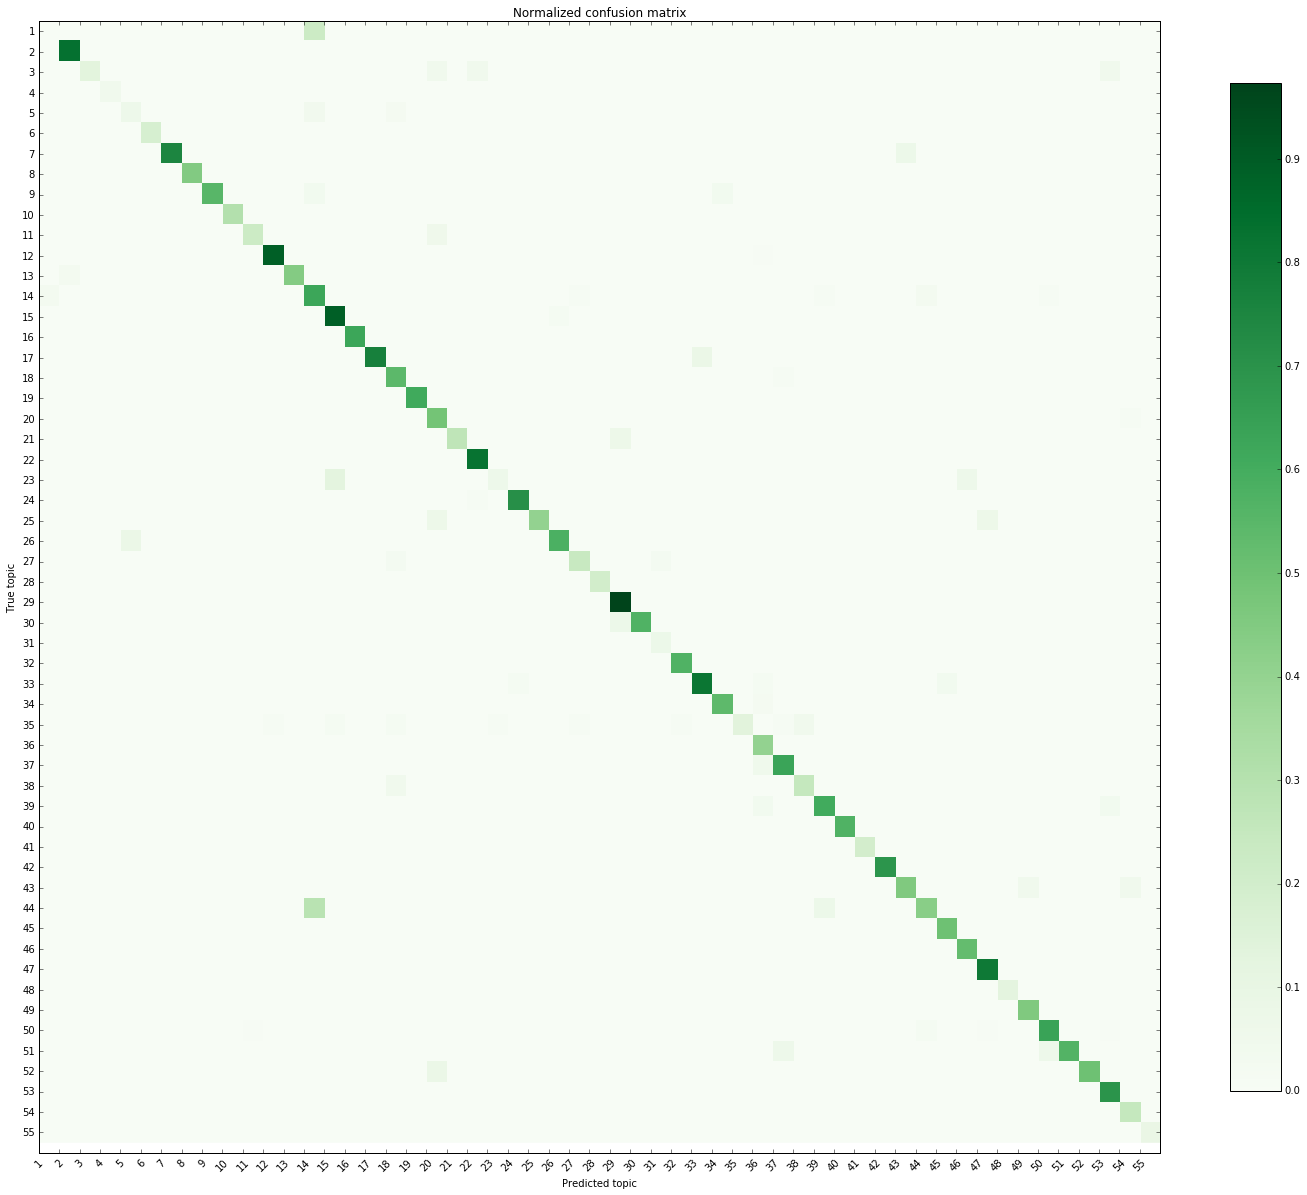

In [54]:
#M = confusion_matrix(y_valid, vw_valid_pred.values)
#M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20,20))
im = plt.imshow(newM, interpolation='nearest', cmap='Greens')
plt.colorbar(im, shrink=0.71)
tick_marks = np.arange(56)
plt.xticks(tick_marks - 0.5, range(1, 56), rotation=45)
plt.yticks(tick_marks, range(1, 56))
plt.tight_layout()
plt.ylabel('True topic')
plt.xlabel('Predicted topic')
plt.title('Normalized confusion matrix')
plt.show()

### Submission

In [289]:
trainvw = open(folder+'train'+handler+'.vw').readlines()
np.random.shuffle(trainvw)
with open(folder+'train'+handler+'.vw', "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [290]:
%%time
!vw --oaa=550 -d {folder}train{handler}.vw \
-f {folder}initial_model{handler}.model -b 28 -c -k \
--passes=30 \
--decay_learning_rate 0.9 --initial_t 0.002337045080352835 \
-l 0.8416950450219994 \ --power_t 0.5 --loss_function='logistic' \
--l1 1e-11 --l2 1e-11 \ -q "sd" -q "sb" --cubic="sbc" \
--stage_poly --batch_sz {len(train_part_file)/6} --batch_sz_no_doubling

creating quadratic features for pairs: sd sb 
creating cubic features for triples: sbc 
using l1 regularization = 1e-11
using l2 regularization = 1e-11
final_regressor = kaggle_data/initial_model_idf_w8.model
Num weight bits = 28
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_idf_w8.vw.cache
Reading datafile = kaggle_data/train_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      224        1       28
1.000000 1.000000            2            2.0      223      224       45
1.000000 1.000000            4            4.0       24      498       47
1.000000 1.000000            8            8.0      364      224       23
1.000000 1.000000           16           16.0      440      224       25
1.000000 1.000000           32           32.0      4

average loss = 0.396340 h

In [291]:
%%time
#Prediction on VALID
!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv --quiet

CPU times: user 364 ms, sys: 80 ms, total: 444 ms
Wall time: 20.2 s


In [292]:
vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.8428323117738542

In [293]:
%%time
# Prediction on TEST!
!vw -i {folder}initial_model{handler}.model -t -d {folder}test{handler}.vw \
-p {folder}vw_test_pred{handler}.csv


creating quadratic features for pairs: sd sb 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_test_pred_idf_w8.csv
Num weight bits = 28
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/test_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown      508       10
1.000000 1.000000            2            2.0  unknown      517       44
1.000000 1.000000            4            4.0  unknown      168       12
1.000000 1.000000            8            8.0  unknown       24       52
1.000000 1.000000           16           16.0  unknown      328       28
1.000000 1.000000           32           32.0  unknown      460       48
1.000000 1.000000           64           64.0  unknown      296       49
1.000000 1.000000          128          128.0 

In [294]:
vw_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)

In [295]:
write_to_submission_file(vw_subm,
                         folder+'25vw_submission'+handler+'.csv')

Score: 0.57276

# Hyperopt

In [138]:
%%time
def hyperopt_train_test(params):
    with open(folder+'train_part'+handler+'.vw') as f:
        train_part_file = f.readlines()
    
    with open(folder+'valid'+handler+'.vw') as f:
        valid_file = f.readlines()
    
    clas_type = params["type"]
    del params["type"]
    
    if clas_type == "ect":
        model = VW(ect=550, passes=30, b=26, convert_to_vw=False, sort_features=True, **params)
    else:
        model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, sort_features=True, **params)
    
    #skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'type': hp.choice('type', ['oaa', 'ect']),
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -20, -9),
    'l1': hp.loguniform('l1', -20, -9),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge", "squared"]),
    'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]),
    'cubic': hp.choice('cubic', ['sbc', 'ibc']),
    'q': hp.choice('q', ["sb", "sc", "sd", "si"])
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/mydb/jobs', exp_key='exp1')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'cubic': 'sbc', 'ftrl': True, 'decay_learning_rate': 0.867574166625138, 'initial_t': 0.2776239270739265, 'l': 0.0434341264970275, 'q': 'si', 'power_t': 1, 'noconstant': True, 'l2': 5.248698547405331e-09, 'loss_function': 'squared', 'l1': 1.541908660931064e-08, 'type': 'ect'}
Accuracy: 0.412161131949 

Testing with params:
{'cubic': 'sbc', 'ftrl': True, 'decay_learning_rate': 0.4380919176573933, 'initial_t': 0.08681977356754463, 'l': 0.2790283913381128, 'q': 'sc', 'power_t': 0.5, 'noconstant': True, 'l2': 1.4656938601889154e-08, 'loss_function': 'hinge', 'l1': 2.5435275529929987e-07, 'type': 'oaa'}
Accuracy: 0.528496935322 

Testing with params:
{'cubic': 'ibc', 'ftrl': False, 'decay_learning_rate': 0.10244638809961329, 'initial_t': 1.0419999810170089, 'l': 0.07462834369874273, 'q': 'si', 'power_t': 1, 'noconstant': False, 'l2': 1.1388346589835574e-06, 'loss_function': 'squared', 'l1': 5.803833976036988e-09, 'type': 'oaa'}
Accuracy: 0.289513005824 

Testing with pa

KeyboardInterrupt: 